In [ ]:
#default_exp analysis

In [ ]:
#export
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Analysis
> Functionalities to perform the model analysis.

In [ ]:
#export
def plot_conf_mat(model, dl, conf=None, fs=(7, 7)):
    "Plots confusion matrix of `model` given a `DataLoader`."
    conf = get_conf_mat(model, dl) if conf is None else conf
    fig, ax = plt.subplots(figsize=fs)
    ax.matshow(conf, cmap='plasma')
    for (i, j), z in np.ndenumerate(conf):
        if i == j: c = 'k'
        else:      c = 'w'
        ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center', fontsize=16, color=c)
    return conf
    
def get_conf_mat(model, dl):
    "Computes confusion matrix of `model` given a `DataLoader`."
    if hasattr(model, 'rnn'): out = [[model(xb)[0].softmax(1).argmax(1).detach().cpu(), yb.cpu()] for xb, yb in dl]
    else:                     out = [[model(xb).softmax(1).argmax(1).detach().cpu(), yb.cpu()] for xb, yb in dl]
    preds, true = torch.cat([o[0] for o in out]), torch.cat([o[1] for o in out])
    np_preds, np_y = np.array(preds), np.array(true)
    return confusion_matrix(np_y, np_preds, normalize='true')

In [ ]:
#hide
from andi_unicorns.utils import *
from andi_unicorns.data import *
from andi_unicorns.models import *
from andi_unicorns.prototypes import RNNCNNClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
dim, task, dm = 1, 1, 4
# names = [f"cnn_dim1_t2_ks3_{i}" for i in range(11)]
# names = [f"cnn_dim{dim}_t{task}_dm{dm}_{i}" for i in range(11)]
# names = [f"hydra_dim1_t{task}_{i}" for i in range(14) if i is not 4]
names = [f"hydra_dim1_t{task}_{i}_custom" for i in range(7)]
models = [load_model(name).cuda() for name in names]
for model in models: model.eval()

In [ ]:
# dls = get_custom_dls(target='exp', models=[dm], split_pct=0.2, balance=False)
dls = get_discriminative_dls(task, split_pct=1.)
predictions, trues = [], []
for model in tqdm(models): 
    if task == 1: 
        if hasattr(model, 'rnn'): out = [[model(xb)[0].squeeze().detach().cpu(), yb.cpu()] for xb, yb in dls[1]]
        else:                     out = [[model(xb).squeeze().detach().cpu(), yb.cpu()] for xb, yb in dls[1]]
    elif task == 2:
        if hasattr(model, 'rnn'): out = [[model(xb)[0].softmax(1).argmax(1).detach().cpu(), yb.cpu()] for xb, yb in dls[1]]
        else:                     out = [[model(xb).softmax(1).argmax(1).detach().cpu(), yb.cpu()] for xb, yb in dls[1]]
    preds, true = torch.cat([o[0] for o in out]), torch.cat([o[1] for o in out])
    np_preds, np_y = np.array(preds), np.array(true)
    predictions.append(np_preds)
    trues.append(np_y)

In [ ]:
preds_exp = np.array(predictions)
maj_exp = np.mean(preds_exp, axis=0)

In [ ]:
maes = [mae(np_y, pred) for pred in preds_exp]
mj_maes = mae(np_y, maj_exp)

In [ ]:
maes, mj_maes

([0.1721727570016682,
  0.16467719452612103,
  0.17097252686992284,
  0.17377498302295805,
  0.16279437048628928,
  0.17015006141364575,
  0.17157220427379014],
 0.1660321052727103)

In [ ]:
pred_cls = np.array(predictions)

In [ ]:
maj_cls = np.array([np.bincount(pred_cls[:, i]).argmax() for i in range(pred_cls.shape[1])])

In [ ]:
new_exps = deepcopy(maj_exp)

In [ ]:
new_exps[(maj_cls == 0) & (maj_exp > 1)] = 1
new_exps[(maj_cls == 1) & (maj_exp > 1)] = 1
new_exps[(maj_cls == 2) & (maj_exp > 1.95)] = 1.95
new_exps[(maj_cls == 3) & (maj_exp < 1.05)] = 1.05

In [ ]:
new_scores = mae(np_y, new_exps)
new_scores

0.16256782183095814

In [ ]:
scores = [f1_score(np_y, pred, average='micro') for pred in pred_cls]
mj_score = f1_score(np_y, maj_cls, average='micro')

In [ ]:
scores, mj_score

([0.8532,
  0.8566,
  0.8581,
  0.85,
  0.8605,
  0.8553,
  0.8536,
  0.853,
  0.8554999999999999,
  0.8553],
 0.8591)

In [ ]:
ens = Ensemble(models, add_act=False)

In [ ]:
save_model(ens, "task1_dim1")

In [ ]:
xb, yb = dls[1].one_batch()
pb = ens(xb)

In [ ]:
maj_cls[:5]

array([1, 3, 3, 1, 1])

In [ ]:
pb[:5]

tensor([[1.6988],
        [0.1513],
        [1.9002],
        [1.8471],
        [0.1643]], device='cuda:0', grad_fn=<SliceBackward>)

In [ ]:
validate_task([ens], 1, [1], bs=128)

In [ ]:
import csv
from pathlib import Path
from copy import deepcopy

In [ ]:
pred_path = Path("../data/preds")
with open(pred_path/"task1.txt", 'r') as e, open(pred_path/"task2.txt", 'r') as c:
    classes = csv.reader(c, delimiter=';', lineterminator="\n", quoting=csv.QUOTE_NONNUMERIC)
    exponents = csv.reader(e, delimiter=';', lineterminator="\n", quoting=csv.QUOTE_NONNUMERIC)
    models = np.array([cl[1:] for cl in classes])
    exps = np.array([exp[1:] for exp in exponents])

In [ ]:
new_exps = deepcopy(exps).squeeze()
cl_preds = np.argmax(models, axis=1)
new_exps[(cl_preds == 1) & (exps.squeeze() > 1)] = 1
new_exps[(cl_preds == 3) & (exps.squeeze() < 1.05)] = 1.05

In [ ]:
with open(pred_path/"task1_.txt", "w") as f:
    for pred in new_exps:
        f.write(f"{int(dim)}; {str(pred)}\n")

In [ ]:
ens_preds = torch.cat([ens(xb).detach().cpu() for xb, _ in dls[1]])
y_true = torch.cat([yb.cpu() for _, yb in dls[1]])
f1_score(y_true, ens_preds, average='micro')

0.8259709587123862

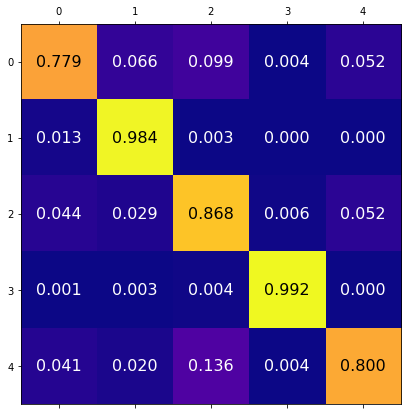

In [ ]:
conf = confusion_matrix(np_y, majority, normalize='true')
_ = plot_conf_mat(model, dls[1], conf=conf)

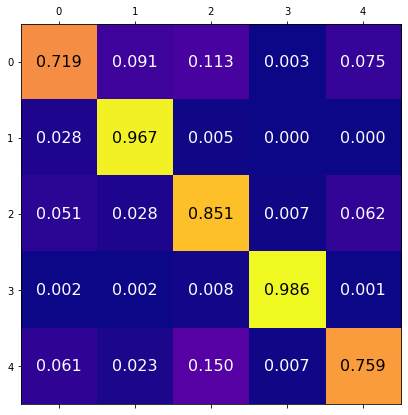

In [ ]:
conf = confusion_matrix(np_y, majority, normalize='true')
_ = plot_conf_mat(model, dls[1], conf=conf)

In [ ]:
from andi_unicorns.data import load_custom_data, load_data

In [ ]:
df = load_custom_data()
mdf = load_data(2)
edf = load_data(1)

In [ ]:
model = load_model("gru_dim1_t2_norm")
dls = get_custom_dls()

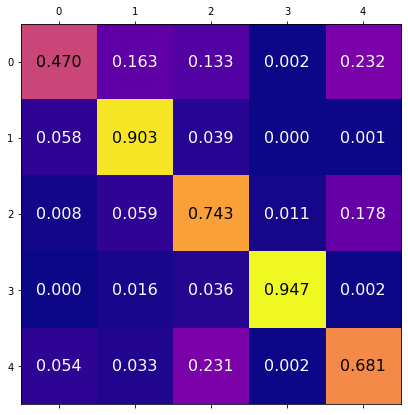

In [ ]:
conf = plot_conf_mat(model, dls[1])

In [ ]:
model = load_model("gru_dim1_t2_1")

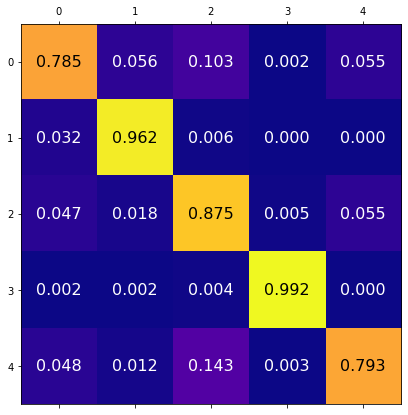

In [ ]:
conf = plot_conf_mat(model, dls[1])

In [ ]:
model = load_model("lstm_dim1_t2_norm")

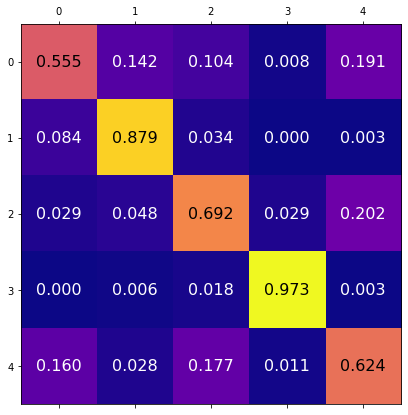

In [ ]:
conf = plot_conf_mat(model, dls[1])

In [ ]:
model = load_model(f"cnn_dim1_t2_norm").cuda()

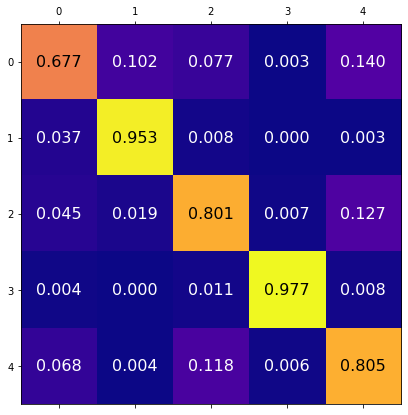

In [ ]:
conf = plot_conf_mat(model, dls[1])

In [ ]:
model = load_model("cnn_dim1_t2_ks5")

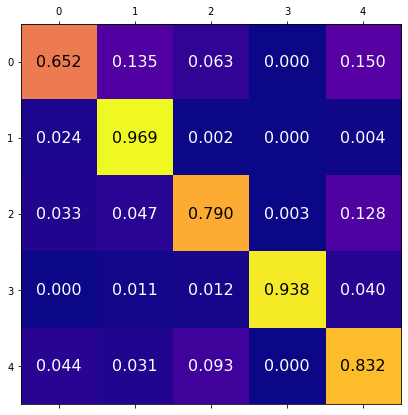

In [ ]:
conf = plot_conf_mat(model, dls[1])

## Export-

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_data.ipynb.
Converted 01_models.ipynb.
Converted 02_prototypes.ipynb.
Converted 03_utils.ipynb.
Converted 04_analysis.ipynb.
Converted index.ipynb.
